<a href="https://colab.research.google.com/github/53-gm/Prog2kakushin/blob/main/work1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

簡易的なマインスイーパ (使用ライブラリ:pandas, numpy, opencv)

どういうゲームなのか:

    私が昔はまっていた"マインスイーパ"というゲームを思い出しながら作ったもの。

    10*10のマスのどこかに爆弾が埋められているという設定。
    その爆弾を避けながらマスを塗りつぶしていく。
    爆弾の場所を塗りつぶすとゲームオーバー。
    爆弾を避け全て塗りつぶすとゲームクリア。

    それだけではただの運ゲーなので、爆弾のない場所を塗りつぶしした時、周りにある爆弾の個数を表示する。

    これでもほとんど運ゲーだが、私が覚えてるマインスイーパの仕様がこの程度なので後は省略

    マインスイーパ
    https://ja.wikipedia.org/wiki/%E3%83%9E%E3%82%A4%E3%83%B3%E3%82%B9%E3%82%A4%E3%83%BC%E3%83%91

マインスイーパを作ろうと思った理由:

    ・csvデータを見つけてくるのが面倒なため、csvを読み込まずに実装可能な作品にしたかったから。
    ・常に更新するのではなく、イベントが起こってから動くので比較的簡単に実装可能だから


・簡易的なマインスイーパの遊び方

    1.何らかのキーを入力し、ゲームをスタートする。(これが無いと何故か画像表示後にキー入力する場所が無くなる可能性がある。)

    2.マインスイーパのゲーム画面表示後選択したい位置を入力する。

    3.その位置に爆弾が無ければ青色に表示され周りの爆弾の個数が表示される。一方、その位置に爆弾があった場合赤色に表示されゲームオーバーとなる。

    4.爆弾以外のマスが無くなったらゲームクリア。そうでなければ2へ戻って位置を選択

    ※今回は実際に遊んでもらう用ではないので爆弾の位置をリスト型で最初に表示している。


Graphics class

OpenCVを使って画面に画像を表示するクラス

In [1]:
import numpy as np
import cv2
import sys
from google.colab.patches import cv2_imshow

class Graphics:
    def __init__(self, windowWidth, windowHeight, windowName, windowColor):
        self.width, self.height = windowWidth, windowHeight
        self.winname = windowName
        self.window = np.zeros( (self.height, self.width, 3), np.uint8 )
        self.windowColor = windowColor
        self.window[:] = (windowColor[0], windowColor[1], windowColor[2])
    def reset(self): #画面のリセット
        self.window = np.zeros( (self.height, self.width, 3), np.uint8 )
        self.window[:] = (self.windowColor[0], self.windowColor[1], self.windowColor[2])
        cv2_imshow(self.window)
    def drawRect(self, p1, p2, color): #四角形の表示 (左上座標, 右下座標, 色)
        cv2.rectangle(self.window, (int(p1[0]), int(p1[1])), (int(p2[0]), int(p2[1])), (color[0],color[1],color[2]), thickness=-1)
    def drawText(self, text: str, p, color, scale :float): #文字の表示 (表示したい文字, 左上座標, 色, 大きさ(倍率)) 
        cv2.putText(self.window, text, (int(p[0]), int(p[1])), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=(color[0], color[1], color[2]), thickness=2)
    def show(self): #画面に表示
        cv2_imshow(self.window)


       


Field class

マインスイーパ本体

In [32]:
import pandas as pd

def calc2dArray(p: int, sizeX: int, sizeY: int): #一次元配列のindexを二次元配列のindexに直す関数 
  x = p % sizeX
  y = p // sizeY
  return x, y

class Field:
    def __init__(self, graphics, fieldSize, chipSize, bomb):
        self.sizeX = fieldSize[0]
        self.sizeY = fieldSize[1]
        self.chipSize = chipSize
        self.g = graphics
        self.field = pd.DataFrame() #データフレーム (point(座標), status(どのような状態か)を持つ予定)

        # ※ statusについて
        #       0 選択されてない
        #       1 選択された
        #       2 選択されて爆弾があった

        self.bomb = bomb

        for i in range(self.sizeX * self.sizeY):  
          self.field = self.field.append({'point':i, 'status':0}, ignore_index=True) #データを入れてく
    
    def select(self, k: int): #選択させるやつ
      if k < 1:
        return False
      self.field['status'][k - 1] = 1
      return True
    
    def searchBomb(self, k): #周りに爆弾があるかどうかみるやつ
      sum = 0
      for i in range(len(bomb)):

        if k > 0:
          if self.field['point'][k - 1] == self.bomb[i] - 1:
            sum += 1
        if k < self.sizeX * self.sizeY: 
          if self.field['point'][k + 1] == self.bomb[i] - 1:
            sum += 1

        if k + self.sizeY <= self.sizeY * self.sizeX - 1:
          if self.field['point'][k + self.sizeY] == self.bomb[i] - 1:
            sum += 1
        if k - self.sizeY >= 0:
          if self.field['point'][k - self.sizeY] == self.bomb[i] - 1:
            sum += 1
      
        
        if k - self.sizeY + 1 >= 0:
          if self.field['point'][k - self.sizeY + 1] == self.bomb[i] - 1:
            sum += 1
        if k - self.sizeY -1 >= 0:
          if self.field['point'][k - self.sizeY - 1] == self.bomb[i] - 1:
            sum += 1
        
        if k + self.sizeY + 1 <= self.sizeY * self.sizeX - 1:
          if self.field['point'][k + self.sizeY + 1] == self.bomb[i] - 1:
            sum += 1
        if k + self.sizeY - 1 <= self.sizeY * self.sizeX - 1:
          if self.field['point'][k + self.sizeY - 1] == self.bomb[i] - 1:
            sum += 1

      return sum
      
    def update(self): #更新作業
      for i in range(len(self.bomb)):  
        if self.field['status'][self.bomb[i] - 1] == 1: #爆弾の場所が選択されたら
          self.field['status'][self.bomb[i] - 1] = 2
          return -1 

      sum = self.field['status'].sum() #選択されている合計

      if sum == (self.sizeX * self.sizeY - len(self.bomb)): 
         for i in range(len(self.bomb)):  
            self.field['status'][self.bomb[i] - 1] = 2
         return 1

      return 0

    def draw(self):
      for i in range(self.sizeX * self.sizeY):
        x, y = calc2dArray(self.field['point'][i], self.sizeX, self.sizeY)
        self.g.drawRect((x * self.chipSize, y * self.chipSize), (x * self.chipSize + self.chipSize, y * self.chipSize + self.chipSize), (255,255,255))  

        if self.field['status'][i] == 1:
          self.g.drawRect((x * self.chipSize, y * self.chipSize), (x * self.chipSize + self.chipSize, y * self.chipSize + self.chipSize), (255,0,0))

        if self.field['status'][i] == 2:
          self.g.drawRect((x * self.chipSize, y * self.chipSize), (x * self.chipSize + self.chipSize, y * self.chipSize + self.chipSize), (0,0,255))

        if self.field['status'][i] != 1:
          self.g.drawText(str(i + 1), (x * self.chipSize, y * self.chipSize + (self.chipSize / 2)), (0, 0, 0), 1.0)
        else:
          self.g.drawText(str(self.searchBomb(i)), (x * self.chipSize, y * self.chipSize + (self.chipSize / 2)), (0, 0, 0), 1.0)

        

Main

[6, 8, 14, 19, 23, 25, 27, 36, 40, 42, 50, 54, 63, 67, 70, 72, 73, 81, 82, 89]
何かキーを入力してください1


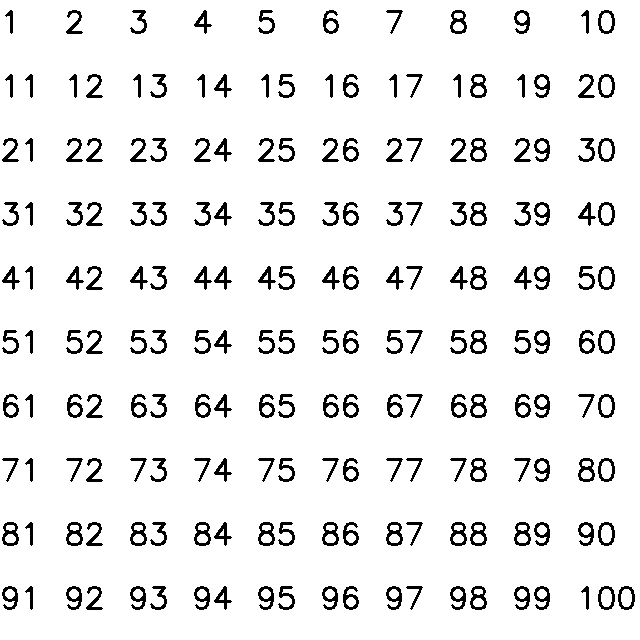

消したい番号を入力してください6


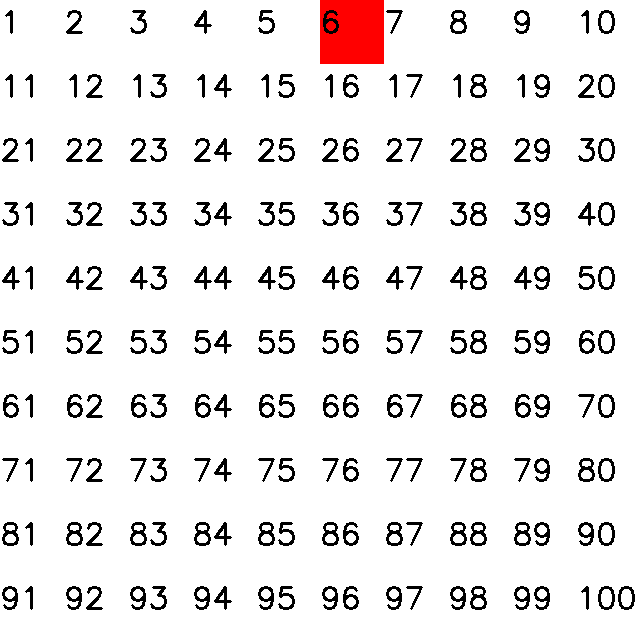

ゲームオーバー！


In [34]:
import numpy as np
import cv2 
import sys 
import time
import random

SIZE_X = 10
SIZE_Y = 10
CHIP_SIZE = 64
WINDOW_WIDTH = CHIP_SIZE * SIZE_X
WINDOW_HEIGHT = CHIP_SIZE * SIZE_Y
BOMB = 20

def randNodup(a, b, k): #乱数 被りなし a = 最低 b = 最高 k = 個数
    if abs(a) + b < k:
        raise ValueError
    r = set()
    while len(r) < k:
        r.add(random.randint(a, b))
    return list(r) 


if __name__ == "__main__":

   bomb = randNodup(1, SIZE_X * SIZE_Y, BOMB)
   print(bomb)

   graphics = Graphics(WINDOW_WIDTH, WINDOW_HEIGHT, 'Test', (255, 0, 255))
   field = Field(graphics, (SIZE_X, SIZE_Y), CHIP_SIZE, bomb)

   

   k = int(input('何かキーを入力してください'))

   while True: 

      u = field.update() 

      field.draw() 

      graphics.show()

      if (u == -1):
        print('ゲームオーバー！')
        break
      elif (u == 1):     
        print('ゲームクリア！')
        break

      k = int(input('消したい番号を入力してください'))

      if k == -1: 
        print("ゲームを中断します")
        break

      if k <= 0 or k > SIZE_X * SIZE_Y:
        print("不正な値です")
        continue

      field.select(k)

   cv2.destroyAllWindows()
